Preprocessing Datasets

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Using Pandas to read Dataset

In [ ]:
import pandas as pd

path ='/content/drive/MyDrive/NLP_Project/ecommerceDataset.csv'

df = pd.read_csv(path)


# df.head()
df.shape

(50424, 2)

Changing Names of Columns

In [ ]:
df = df.rename(columns={df.columns[1]: "Description"})
df = df.rename(columns={df.columns[0]: "Category"})

In [ ]:
df.columns

Index(['Category', 'Description'], dtype='object')

In [ ]:
df.head()

,Category,Description
0,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
1,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
2,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
3,Household,Incredible Gifts India Wooden Happy Birthday U...
4,Household,Pitaara Box Romantic Venice Canvas Painting 6m...


In [ ]:
df.iloc[40000:40011].head()

,Category,Description
40000,Electronics,BEBIG SATA/PATA/IDE Drive to USB 2.0 Adapter C...
40001,Electronics,BEBIG SATA/PATA/IDE Drive to USB 2.0 Adapter C...
40002,Electronics,plutofit SATA/IDE to USB 2.0 Adapter with Powe...
40003,Electronics,Technotech USB to IDE SATA Convertor with Powe...
40004,Electronics,Ophion USB 3.0 to SATA 22 Pin Data Sync Cable ...


Basic Exploratory Data Analysis

In [ ]:

print(df.info())
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nCategory distribution (top 20):")
print(df['Category'].value_counts().head(20))
print("\nSample descriptions:")
display(df['Description'].sample(6).reset_index(drop=True))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50424 entries, 0 to 50423
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Category     50424 non-null  object
 1   Description  50423 non-null  object
dtypes: object(2)
memory usage: 788.0+ KB
None

Missing values per column:
Category       0
Description    1
dtype: int64

Category distribution (top 20):
Category
Household                 19312
Books                     11820
Electronics               10621
Clothing & Accessories     8671
Name: count, dtype: int64

Sample descriptions:


,Description
0,Mamma's Maternity Rayon Printed Maternity Dres...
1,Epson L380 Multi-Function InkTank Colour Print...
2,AM Stone Lace 6-line for Jewellery Decoration ...
3,Casio LC-160LV Portable Calculator (Black)
4,IFB 6 kg Fully-Automatic Front Loading Washing...
5,Icable Artist Drawing Two Finger Glove for Gra...


Removing uneccesary data

In [ ]:

# 1. Remove rows where Category or Description is missing (NaN / empty)
df = df.dropna(subset=['Category', 'Description']).reset_index(drop=True)

# 2. Remove duplicate rows (same Category + Description)
df = df.drop_duplicates(subset=['Category', 'Description']).reset_index(drop=True)

# 3. Remove rows where Description is extremely short (e.g., less than 3 characters)
df['desc_len'] = df['Description'].astype(str).str.len()
df = df[df['desc_len'] >= 3].reset_index(drop=True)

# 4. (Optional) Drop the helper column
df = df.drop(columns=['desc_len'])

print("After cleaning shape:", df.shape)
df.head()

After cleaning shape: (27801, 2)


,Category,Description
0,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
1,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
2,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
3,Household,Incredible Gifts India Wooden Happy Birthday U...
4,Household,Pitaara Box Romantic Venice Canvas Painting 6m...


Basic text normalization

In [ ]:

import re

def clean_text_basic(s):
    s = str(s)
    s = s.strip()
    s = s.lower()
    # remove html tags
    s = re.sub(r'<[^>]+>', ' ', s)
    # remove urls
    s = re.sub(r'http\S+|www\.\S+', ' ', s)
    # remove SKU-like tokens (SKU:1234 or SKU-123)
    s = re.sub(r'\bsku[:\s-]*\w+\b', ' ', s)
    # split joined numbers/letters (2kg -> 2 kg)
    s = re.sub(r'(\d)([a-zA-Z])', r'\1 \2', s)
    s = re.sub(r'([a-zA-Z])(\d)', r'\1 \2', s)
    # remove extra whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    return s

df['Description'] = df['Description'].apply(clean_text_basic)
df.head()


,Category,Description
0,Household,"saf 'floral' framed painting (wood, 30 inch x ..."
1,Household,saf 'uv textured modern art print framed' pain...
2,Household,"saf flower print framed painting (synthetic, 1..."
3,Household,incredible gifts india wooden happy birthday u...
4,Household,pitaara box romantic venice canvas painting 6 ...


In [ ]:
# !pip install -q tqdm


In [ ]:
# !python -m spacy download en_core_web_md



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 43.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Performing Lemmatization and Removing useless words

In [ ]:
import re
from tqdm import tqdm
import spacy

nlp = spacy.load("en_core_web_md", disable=["parser", "ner"])

# keep only words we truly do not want in product descriptions
BAD_WORDS = {
    "quality", "original", "brand", "new", "best", "high", "premium", "latest",
    "perfect", "good", "excellent", "durable", "long", "use", "product"
}

def clean_dimensions(text):
    text = str(text).lower()
    text = re.sub(r'\b\d+\s*[x×]\s*\d+\s*\w+\b', ' ', text)
    text = re.sub(r'\b\d+\s*(cm|mm|kg|g|mg|lbs|lb|inch|inches|ft|meter|m|ml|ltr|liter|litre)\b', ' ', text)
    text = re.sub(r'\bx\b', ' ', text)
    return re.sub(r'\s+', ' ', text).strip()

def preprocess(texts):
    cleaned = [clean_dimensions(t) for t in texts]
    processed = []

    for doc in tqdm(nlp.pipe(cleaned, batch_size=700), total=len(cleaned), desc="Cleaning"):
        tokens = []
        for token in doc:
            if token.is_alpha:
                lemma = token.lemma_.lower()
                if lemma not in BAD_WORDS:
                    tokens.append(lemma)
        processed.append(" ".join(tokens))  # ✅ KEEP FULL LENGTH

    return processed

df['Description'] = preprocess(df['Description'])
df.head()


Cleaning: 100%|██████████| 27801/27801 [00:22<00:00, 1213.14it/s]


,Category,Description
0,Household,saf floral framed painting wood inch special e...
1,Household,saf uv texture modern art print frame paint sy...
2,Household,saf flower print frame paint synthetic inch uv...
3,Household,incredible gift india wooden happy birthday un...
4,Household,pitaara box romantic venice canvas paint mm th...


In [ ]:
df.iloc[25000:250010].head()

,Category,Description
25000,Electronics,boult audio flex ear wireless bluetooth headph...
25001,Electronics,nu republic starboy wireless headphone mic bla...
25002,Electronics,zaptin magnet technology bluetooth headphone m...
25003,Electronics,zoook jazz duo bluetooth headphone speaker mus...
25004,Electronics,boat rockerz wireless bluetooth headphone blac...


In [ ]:
df.to_csv("processed_data.csv", index=False)

In [6]:
import pandas as pd
import numpy as np


path = '/content/drive/MyDrive/NLP_Project/processed_data_70169556.csv'

df = pd.read_csv(path)
df.head()

,Category,Description
0,Household,saf floral framed painting wood inch special e...
1,Household,saf uv texture modern art print frame paint sy...
2,Household,saf flower print frame paint synthetic inch uv...
3,Household,incredible gift india wooden happy birthday un...
4,Household,pitaara box romantic venice canvas paint mm th...


In [ ]:
# !pip install tqdm


In [7]:
df["Description"] = df["Description"].astype(str)

df = df[
    (df["Description"].str.strip() != "") &
    (df["Description"].str.strip().str.lower() != "nan")
]

df = df.reset_index(drop=True)




In [ ]:
df.shape

(27799, 2)

TDF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import pandas as pd

# FIX NaN values
df['Description'] = df['Description'].fillna('')

# Limit features to avoid memory crash
tfidf = TfidfVectorizer(stop_words='english', max_features=3000)

tfidf_matrix = tfidf.fit_transform(df['Description'])

# Convert sparse matrix to dense with progress bar
dense_matrix = []

for i in tqdm(range(tfidf_matrix.shape[0]), desc="Converting TF-IDF matrix"):
    dense_matrix.append(tfidf_matrix[i].toarray()[0])

# Create DataFrame
tfidf_df = pd.DataFrame(dense_matrix, columns=tfidf.get_feature_names_out())

# Add category column
tfidf_df['Category'] = df['Category']

# Save ONE file
tfidf_df.to_csv("products_tfidf.csv", index=False)



Converting TF-IDF matrix:  43%|████▎     | 12068/27799 [00:01<00:02, 7135.70it/s]


KeyboardInterrupt: 

Bag of Words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
import pandas as pd

df['Description'] = df['Description'].fillna('')

# Limit features for safety
bow = CountVectorizer(stop_words='english', max_features=3000)

bow_matrix = bow.fit_transform(df['Description'])

# Dense conversion with progress bar
dense = []
for i in tqdm(range(bow_matrix.shape[0]), desc="Processing Bag of Words"):
    dense.append(bow_matrix[i].toarray()[0])

bow_df = pd.DataFrame(dense, columns=bow.get_feature_names_out())
bow_df['Category'] = df['Category']

bow_df.to_csv("products_bow.csv", index=False)



Processing Bag of Words: 100%|██████████| 27799/27799 [00:01<00:00, 15501.44it/s]


One-hot encoding

In [ ]:
import pandas as pd

df['Description'] = df['Description'].fillna('')

# One-hot encode category column
ohe_df = pd.get_dummies(df, columns=['Category'])

ohe_df.to_csv("products_ohe.csv", index=False)




In [ ]:
pip install pandas numpy gensim tensorflow scikit-learn matplotlib transformers datasets evaluate torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.4 MB/s eta 0:00:00


Word2Vec

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load
# df = pd.read_csv("/content/drive/MyDrive/NLP_Project/processed_data_70169556.csv")  # path to your dataset
# Example preview:
# Category, Description
# Household, "saf floral framed painting wood inch special e..."
# ...

# If descriptions are token lists stored as strings like "['word1','word2']"
# convert them to space-joined strings. If already string, leave.
def to_text(x):
    if isinstance(x, str):
        # If looks like a list repr, attempt to evaluate safely
        if x.startswith('[') and x.endswith(']'):
            try:
                import ast
                toks = ast.literal_eval(x)
                if isinstance(toks, (list,tuple)):
                    return " ".join(toks)
            except Exception:
                pass
        return x
    elif isinstance(x, (list, tuple)):
        return " ".join(x)
    else:
        return str(x)

df['text'] = df['Description'].apply(to_text)
df['label'] = LabelEncoder().fit_transform(df['Category'])
num_classes = df['label'].nunique()

train_df, val_df = train_test_split(df, test_size=0.12, stratify=df['label'], random_state=42)
print(len(train_df), len(val_df), "classes:", num_classes)


24463 3336 classes: 4


In [10]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load your data
df = pd.read_csv("/content/drive/MyDrive/NLP_Project/processed_data_70169556.csv")

# Create the label encoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['Category'])

# Show the mapping
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping (Category -> Number):")
print(label_mapping)

# Create id2label (Number -> Category)
id2label = {str(i): cat for cat, i in label_mapping.items()}
print("\nid2label (Number -> Category):")
print(id2label)

Label Mapping (Category -> Number):
{'Books': np.int64(0), 'Clothing & Accessories': np.int64(1), 'Electronics': np.int64(2), 'Household': np.int64(3)}

id2label (Number -> Category):
{'0': 'Books', '1': 'Clothing & Accessories', '2': 'Electronics', '3': 'Household'}


Fast Text

In [ ]:
from gensim.models import Word2Vec, FastText

# prepare sentences: lists of tokens
sentences = [txt.split() for txt in train_df['text'].tolist()]

# Word2Vec
w2v_model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, workers=4, epochs=10)
w2v_model.save("w2v_sentences.model")

# FastText
ft_model = FastText(sentences=sentences, vector_size=100, window=5, min_count=1, workers=4, epochs=10)
ft_model.save("ft_sentences.model")


Glove

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip


--2025-12-07 06:54:34--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-12-07 06:54:34--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-12-07 06:54:34--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
# load glove into dict
def load_glove(path):
    embeddings_index = {}
    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            parts = line.rstrip().split(' ')
            word = parts[0]
            vec = np.asarray(parts[1:], dtype='float32')
            embeddings_index[word] = vec
    return embeddings_index

glove_path = "/content/glove.6B.100d.txt"
glove_index = load_glove(glove_path)
len(glove_index)


400000

**Model Definition:**

**DeBERTa-v3-small (product-description classification)**

A compact transformer encoder used to classify products from their descriptions.

**Core flow:**

raw text → tokenizer → DeBERTa-v3 encoder → pooled embedding → classifier head → softmax → category.

**Key components:**

**Tokenizer:**

Converts raw text into tokens or subwords that the model can process. It also adds special tokens like [CLS] (for classification) and [SEP] (for separation), and maps tokens to numerical IDs. This allows the transformer to process textual data numerically.

**Transformer encoder (DeBERTa-v3-small):**

Processes the token sequence to generate contextual embeddings, where each
token captures the meaning of the word in context of the full description.

Uses multi-head self-attention to let each token attend to all other tokens, capturing relationships.

Feed-forward layers transform embeddings to richer representations.

Residual connections and layer normalization stabilize training and improve learning.

**Pooling (CLS or mean):**

Aggregates token-level embeddings into a single fixed-length vector representing the entire description.

**CLS pooling**:

Uses the embedding of the special [CLS] token.

**Mean pooling:**

Computes the average of all token embeddings.
This step ensures a consistent vector size regardless of description length.

**Classifier head (Dense → GELU → Dropout → Dense):**

Converts the pooled embedding into logits for each category.

**Dense layers:**

Learn patterns from embeddings to predict categories.

**GELU activation:**

Introduces non-linearity for better representation learning.

**Dropout:**

Randomly disables neurons during training to prevent overfitting and improve generalization.

**Softmax layer:**

Converts logits into probabilities for each category. The category with the highest probability is chosen as the predicted class.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_VOCAB = 30000
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['text'].tolist())

# sequences
max_len = 120  # tune it; choose based on distribution of token lengths
X_train_seq = tokenizer.texts_to_sequences(train_df['text'].tolist())
X_val_seq = tokenizer.texts_to_sequences(val_df['text'].tolist())
X_train = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')

y_train = np.array(train_df['label'].tolist())
y_val = np.array(val_df['label'].tolist())

word_index = tokenizer.word_index
vocab_size = min(MAX_VOCAB, len(word_index) + 1)


In [ ]:
def build_embedding_matrix_from_gensim(gensim_model, word_index, vocab_size, dim=100):
    matrix = np.random.normal(size=(vocab_size, dim)).astype('float32') * 0.01
    for word, i in word_index.items():
        if i >= vocab_size: continue
        try:
            vec = gensim_model.wv[word]
            matrix[i] = vec
        except KeyError:
            pass
    return matrix

def build_embedding_matrix_from_glove(glove_index, word_index, vocab_size, dim=100):
    matrix = np.random.normal(size=(vocab_size, dim)).astype('float32') * 0.01
    for word, i in word_index.items():
        if i >= vocab_size: continue
        vec = glove_index.get(word)
        if vec is not None:
            matrix[i] = vec
    return matrix

# create matrices
w2v_matrix = build_embedding_matrix_from_gensim(w2v_model, word_index, vocab_size, dim=100)
ft_matrix = build_embedding_matrix_from_gensim(ft_model, word_index, vocab_size, dim=100)
glove_matrix = build_embedding_matrix_from_glove(glove_index, word_index, vocab_size, dim=100)


BiLSTM Word 2 Vec

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def make_bilstm_model(vocab_size, embedding_matrix, max_len, num_classes, trainable=False, dropout=0.3):
    inp = Input(shape=(max_len,), dtype='int32')
    emb = Embedding(input_dim=vocab_size,
                    output_dim=embedding_matrix.shape[1],
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=trainable)(inp)
    x = Bidirectional(LSTM(128, return_sequences=False))(emb)
    x = Dropout(dropout)(x)
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# choose embedding: w2v_matrix, ft_matrix, or glove_matrix
embedding_matrix = w2v_matrix  # change as experiment
model = make_bilstm_model(vocab_size, embedding_matrix, max_len, num_classes, trainable=False)
model.summary()

# callbacks
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
cp = ModelCheckpoint("bilstm_best.h5", monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=12,
    batch_size=64,
    callbacks=[es, cp]
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 100)       │     2,304,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,540,324 (9.69 MB)

 Trainable params: 235,524 (920.02 KB)

 Non-trainable params: 2,304,800 (8.79 MB)

Epoch 1/12
382/383 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8805 - loss: 0.3923

383/383 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.8807 - loss: 0.3919 - val_accuracy: 0.9269 - val_loss: 0.2476
Epoch 2/12
380/383 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9280 - loss: 0.2524

383/383 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9280 - loss: 0.2524 - val_accuracy: 0.9311 - val_loss: 0.2272
Epoch 3/12
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9292 - loss: 0.2381

383/383 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9292 - loss: 0.2381 - val_accuracy: 0.9314 - val_loss: 0.2258
Epoch 4/12
381/383 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9329 - loss: 0.2278

383/383 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9329 - loss: 0.2278 - val_accuracy: 0.9344 - val_loss: 0.2168
Epoch 5/12
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9346 - loss: 0.2216 - val_accuracy: 0.9362 - val_loss: 0.2217
Epoch 6/12
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9373 - loss: 0.2054 - val_accuracy: 0.9329 - val_loss: 0.2178
Epoch 7/12
380/383 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9427 - loss: 0.1950

383/383 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9427 - loss: 0.1950 - val_accuracy: 0.9356 - val_loss: 0.2135
Epoch 8/12
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9444 - loss: 0.1804

383/383 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9444 - loss: 0.1804 - val_accuracy: 0.9379 - val_loss: 0.2017
Epoch 9/12
383/383 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9498 - loss: 0.1651 - val_accuracy: 0.9379 - val_loss: 0.2089
Epoch 10/12
383/383 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9503 - loss: 0.1666 - val_accuracy: 0.9376 - val_loss: 0.2088
Epoch 11/12
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9570 - loss: 0.1428 - val_accuracy: 0.9359 - val_loss: 0.2096


In [ ]:
import pickle

with open("tokenizer_bilstm_w2v.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


In [ ]:
import json

with open("config.json", "w") as f:
    json.dump({"max_len": max_len}, f)


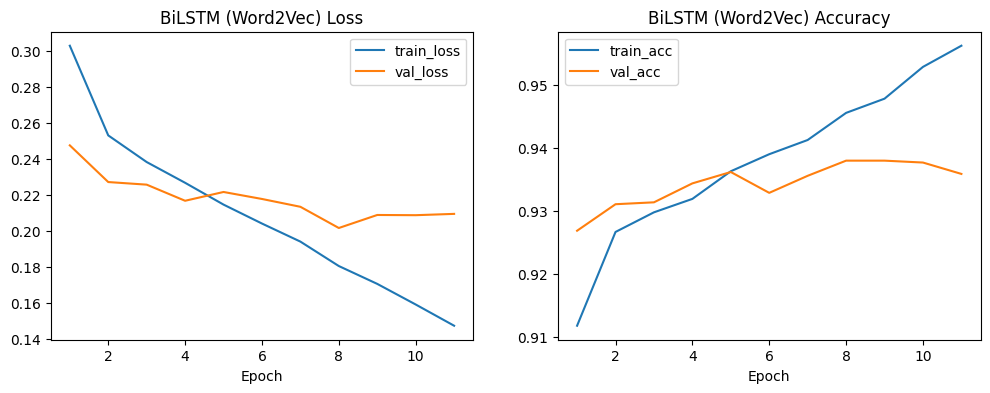

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, title_prefix="BiLSTM"):
    h = history.history
    epochs = range(1, len(h['loss'])+1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, h['loss'], label='train_loss')
    plt.plot(epochs, h['val_loss'], label='val_loss')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, h['accuracy'], label='train_acc')
    plt.plot(epochs, h['val_accuracy'], label='val_acc')
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

plot_history(history, "BiLSTM (Word2Vec)")


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Val accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
print("Confusion matrix:\n", cm)


105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Val accuracy: 0.9379496402877698
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       750
           1       0.96      0.97      0.96       681
           2       0.94      0.89      0.91       637
           3       0.92      0.95      0.93      1268

    accuracy                           0.94      3336
   macro avg       0.94      0.93      0.94      3336
weighted avg       0.94      0.94      0.94      3336

Confusion matrix:
 [[ 701    3   10   36]
 [   6  658    4   13]
 [  11    2  566   58]
 [  20   20   24 1204]]


BiLSTM With Fast text

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def make_bilstm_model(vocab_size, embedding_matrix, max_len, num_classes, trainable=False, dropout=0.3):
    inp = Input(shape=(max_len,), dtype='int32')
    emb = Embedding(input_dim=vocab_size,
                    output_dim=embedding_matrix.shape[1],
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=trainable)(inp)
    x = Bidirectional(LSTM(128, return_sequences=False))(emb)
    x = Dropout(dropout)(x)
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# choose embedding: w2v_matrix, ft_matrix, or glove_matrix
embedding_matrix = ft_matrix  # change as experiment
model = make_bilstm_model(vocab_size, embedding_matrix, max_len, num_classes, trainable=False)
model.summary()

# callbacks
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
cp = ModelCheckpoint("bilstm_ft.h5", monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=12,
    batch_size=64,
    callbacks=[es, cp]
)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 120, 100)       │     2,304,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,540,324 (9.69 MB)

 Trainable params: 235,524 (920.02 KB)

 Non-trainable params: 2,304,800 (8.79 MB)

Epoch 1/12
380/383 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8744 - loss: 0.3933

383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.8747 - loss: 0.3925 - val_accuracy: 0.9257 - val_loss: 0.2469
Epoch 2/12
380/383 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9219 - loss: 0.2583

383/383 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9219 - loss: 0.2583 - val_accuracy: 0.9278 - val_loss: 0.2348
Epoch 3/12
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9270 - loss: 0.2408

383/383 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9270 - loss: 0.2408 - val_accuracy: 0.9305 - val_loss: 0.2262
Epoch 4/12
381/383 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9315 - loss: 0.2276

383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9314 - loss: 0.2277 - val_accuracy: 0.9308 - val_loss: 0.2234
Epoch 5/12
380/383 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9353 - loss: 0.2158

383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9353 - loss: 0.2158 - val_accuracy: 0.9335 - val_loss: 0.2161
Epoch 6/12
380/383 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9376 - loss: 0.2032

383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9376 - loss: 0.2032 - val_accuracy: 0.9341 - val_loss: 0.2141
Epoch 7/12
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9429 - loss: 0.1892

383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9429 - loss: 0.1892 - val_accuracy: 0.9365 - val_loss: 0.2095
Epoch 8/12
383/383 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9447 - loss: 0.1808 - val_accuracy: 0.9362 - val_loss: 0.2120
Epoch 9/12
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9493 - loss: 0.1658 - val_accuracy: 0.9371 - val_loss: 0.2183
Epoch 10/12
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9533 - loss: 0.1514 - val_accuracy: 0.9344 - val_loss: 0.2223


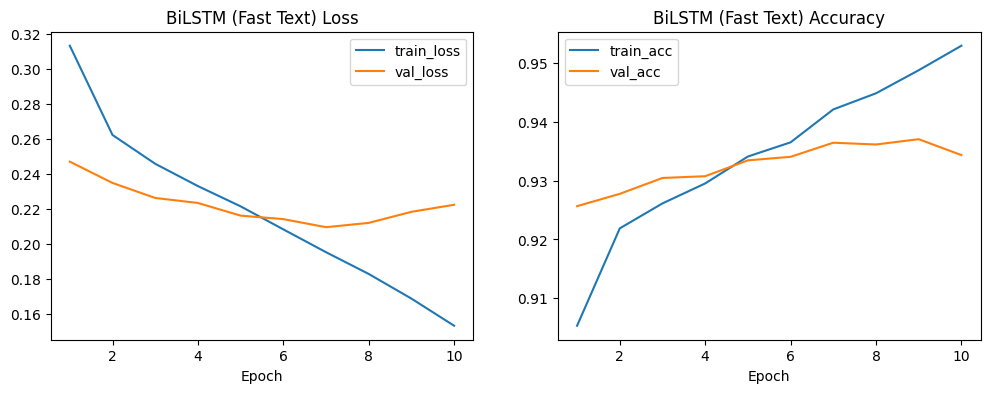

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, title_prefix="BiLSTM"):
    h = history.history
    epochs = range(1, len(h['loss'])+1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, h['loss'], label='train_loss')
    plt.plot(epochs, h['val_loss'], label='val_loss')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, h['accuracy'], label='train_acc')
    plt.plot(epochs, h['val_accuracy'], label='val_acc')
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

plot_history(history, "BiLSTM (Fast Text)")


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Val accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
print("Confusion matrix:\n", cm)


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Val accuracy: 0.9364508393285371
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       750
           1       0.97      0.97      0.97       681
           2       0.91      0.89      0.90       637
           3       0.92      0.95      0.93      1268

    accuracy                           0.94      3336
   macro avg       0.94      0.93      0.94      3336
weighted avg       0.94      0.94      0.94      3336

Confusion matrix:
 [[ 695    7   13   35]
 [   5  658    3   15]
 [   9    3  570   55]
 [  14   12   41 1201]]


BiLSTM GLove

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def make_bilstm_model(vocab_size, embedding_matrix, max_len, num_classes, trainable=False, dropout=0.3):
    inp = Input(shape=(max_len,), dtype='int32')
    emb = Embedding(input_dim=vocab_size,
                    output_dim=embedding_matrix.shape[1],
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=trainable)(inp)
    x = Bidirectional(LSTM(128, return_sequences=False))(emb)
    x = Dropout(dropout)(x)
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# choose embedding: w2v_matrix, ft_matrix, or glove_matrix
embedding_matrix = glove_matrix  # change as experiment
model = make_bilstm_model(vocab_size, embedding_matrix, max_len, num_classes, trainable=False)
model.summary()

# callbacks
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
cp = ModelCheckpoint("bilstm_glove.h5", monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=12,
    batch_size=64,
    callbacks=[es, cp]
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 120, 100)       │     2,304,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,540,324 (9.69 MB)

 Trainable params: 235,524 (920.02 KB)

 Non-trainable params: 2,304,800 (8.79 MB)

Epoch 1/12
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8177 - loss: 0.5092

383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8179 - loss: 0.5088 - val_accuracy: 0.9182 - val_loss: 0.2639
Epoch 2/12
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9210 - loss: 0.2573

383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9210 - loss: 0.2573 - val_accuracy: 0.9308 - val_loss: 0.2253
Epoch 3/12
381/383 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9326 - loss: 0.2235

383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9326 - loss: 0.2235 - val_accuracy: 0.9391 - val_loss: 0.2045
Epoch 4/12
380/383 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9416 - loss: 0.1949

383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9416 - loss: 0.1949 - val_accuracy: 0.9439 - val_loss: 0.1846
Epoch 5/12
382/383 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9511 - loss: 0.1649

383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9511 - loss: 0.1649 - val_accuracy: 0.9469 - val_loss: 0.1756
Epoch 6/12
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9585 - loss: 0.1404 - val_accuracy: 0.9493 - val_loss: 0.1757
Epoch 7/12
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9652 - loss: 0.1206 - val_accuracy: 0.9457 - val_loss: 0.1757
Epoch 8/12
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9713 - loss: 0.1011 - val_accuracy: 0.9436 - val_loss: 0.1910


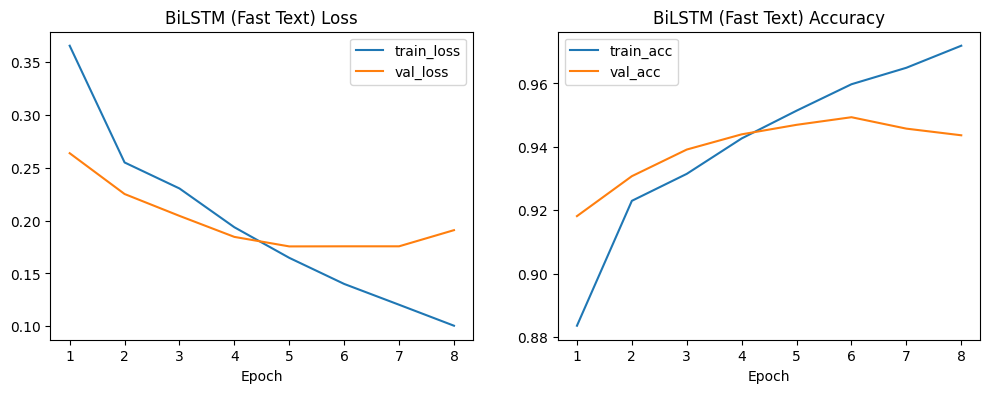

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, title_prefix="BiLSTM"):
    h = history.history
    epochs = range(1, len(h['loss'])+1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, h['loss'], label='train_loss')
    plt.plot(epochs, h['val_loss'], label='val_loss')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, h['accuracy'], label='train_acc')
    plt.plot(epochs, h['val_accuracy'], label='val_acc')
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

plot_history(history, "BiLSTM (Fast Text)")


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Val accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
print("Confusion matrix:\n", cm)


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Val accuracy: 0.9469424460431655
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       750
           1       0.96      0.97      0.97       681
           2       0.95      0.91      0.93       637
           3       0.93      0.96      0.94      1268

    accuracy                           0.95      3336
   macro avg       0.95      0.94      0.95      3336
weighted avg       0.95      0.95      0.95      3336

Confusion matrix:
 [[ 706    7   10   27]
 [   5  661    1   14]
 [   8    3  580   46]
 [  20   14   22 1212]]


BiLSTM with glove 6B 100d gave the best accuracy and overall performance measures

De-Berta-V3-small Starts from here


In [ ]:
!pip install transformers datasets accelerate -q

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import Dataset
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# ============================================================================
# 1. LOAD AND PREPROCESS DATA
# ============================================================================

path = '/content/drive/MyDrive/NLP_Project/processed_data_70169556.csv'
df = pd.read_csv(path)

print(f"Dataset shape: {df.shape}")
print(f"\nCategory distribution:\n{df['Category'].value_counts()}")

# Convert Description to text (if stored as token lists)
def to_text(x):
    if isinstance(x, str):
        if x.startswith('[') and x.endswith(']'):
            try:
                import ast
                toks = ast.literal_eval(x)
                if isinstance(toks, (list, tuple)):
                    return " ".join(toks)
            except Exception:
                pass
        return x
    elif isinstance(x, (list, tuple)):
        return " ".join(x)
    else:
        return str(x)

df['text'] = df['Description'].apply(to_text)

# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Category'])
num_classes = df['label'].nunique()

# Create label mapping for later reference
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# Convert numpy int64 to Python int for JSON serialization
id2label = {int(v): str(k) for k, v in label_mapping.items()}
label2id = {str(k): int(v) for k, v in label_mapping.items()}

print(f"\nNumber of classes: {num_classes}")
print(f"Label mapping: {label_mapping}")

# Split data
train_df, val_df = train_test_split(
    df[['text', 'label']],
    test_size=0.12,
    stratify=df['label'],
    random_state=42
)

print(f"\nTrain size: {len(train_df)}, Val size: {len(val_df)}")

Dataset shape: (27801, 2)

Category distribution:
Category
Household                 10563
Books                      6256
Clothing & Accessories     5674
Electronics                5308
Name: count, dtype: int64

Number of classes: 4
Label mapping: {'Books': np.int64(0), 'Clothing & Accessories': np.int64(1), 'Electronics': np.int64(2), 'Household': np.int64(3)}

Train size: 24464, Val size: 3337


In [ ]:
MODEL_NAME = "microsoft/deberta-v3-small"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df.reset_index(drop=True))

# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding=False,  # Will be handled by data collator
        truncation=True,
        max_length=512
    )

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/24464 [00:00<?, ? examples/s]

Map:   0%|          | 0/3337 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_classes,
    id2label=id2label,
    label2id=label2id
)

# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./deberta_classifier",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir='./logs',
    logging_steps=50,
    save_total_limit=2,
    fp16=True,  # Use mixed precision if GPU supports it
    report_to="none"
)

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# ============================================================================
# 7. TRAIN
# ============================================================================

print("\n" + "="*50)
print("STARTING TRAINING")
print("="*50 + "\n")

trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.



STARTING TRAINING



Epoch,Training Loss,Validation Loss,Accuracy
1,0.239900,0.189114,0.952952
2,0.213400,0.195042,0.957746
3,0.158100,0.190582,0.960743


TrainOutput(global_step=4587, training_loss=0.2094126137508295, metrics={'train_runtime': 523.2436, 'train_samples_per_second': 140.264, 'train_steps_per_second': 8.766, 'total_flos': 360755140228992.0, 'train_loss': 0.2094126137508295, 'epoch': 3.0})

In [ ]:
print("\n" + "="*50)
print("EVALUATION ON VALIDATION SET")
print("="*50 + "\n")

eval_results = trainer.evaluate()
print(f"Validation Accuracy: {eval_results['eval_accuracy']:.4f}")

# Get predictions for detailed metrics
predictions = trainer.predict(val_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))


EVALUATION ON VALIDATION SET



Validation Accuracy: 0.9607

Classification Report:
                        precision    recall  f1-score   support

                 Books       0.97      0.95      0.96       751
Clothing & Accessories       0.97      0.98      0.98       681
           Electronics       0.95      0.94      0.95       637
             Household       0.96      0.96      0.96      1268

              accuracy                           0.96      3337
             macro avg       0.96      0.96      0.96      3337
          weighted avg       0.96      0.96      0.96      3337


Confusion Matrix:
[[ 714    7    8   22]
 [   1  670    2    8]
 [  10    3  601   23]
 [  11   13   23 1221]]


In [ ]:
model.save_pretrained("/content/drive/MyDrive/NLP_Project/deberta")
tokenizer.save_pretrained("/content/drive/MyDrive/NLP_Project/deberta")
print("\nModel saved to '/content/drive/MyDrive/NLP_Project/deberta'")


Model saved to '/content/drive/MyDrive/NLP_Project/deberta'


In [11]:
import gradio as gr
import torch
import tensorflow as tf
import numpy as np
import json
import pickle
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
# ============================================================================
# PATHS
# ============================================================================
DEBERTA_PATH = "/content/drive/MyDrive/NLP_Project/deberta"
BILSTM_PATH = "/content/drive/MyDrive/NLP_Project/BiLSTM"

# ============================================================================
# LOAD DEBERTA MODEL (FROM YOUR TRAINED MODEL)
# ============================================================================
print("Loading DeBERTa model...")
deberta_tokenizer = AutoTokenizer.from_pretrained(DEBERTA_PATH)  # Load YOUR tokenizer
deberta_model = AutoModelForSequenceClassification.from_pretrained(DEBERTA_PATH)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
deberta_model.to(device)
deberta_model.eval()
print("✓ DeBERTa loaded from your trained model")
print(f"✓ DeBERTa categories: {deberta_model.config.id2label}")

# ============================================================================
# LOAD BILSTM MODELS AND CONFIG
# ============================================================================
print("\nLoading BiLSTM models...")

# Load config (only has max_len)
with open(f"{BILSTM_PATH}/config.json", 'r') as f:
    bilstm_config = json.load(f)

# Load tokenizer
with open(f"{BILSTM_PATH}/tokenizer_bilstm_w2v.pkl", 'rb') as f:
    bilstm_tokenizer = pickle.load(f)

# Load all three BiLSTM models
bilstm_w2v = load_model(f"{BILSTM_PATH}/bilstm_w2v.h5")
bilstm_ft = load_model(f"{BILSTM_PATH}/bilstm_ft.h5")
bilstm_glove = load_model(f"{BILSTM_PATH}/bilstm_glove.h5")

max_len = bilstm_config['max_len']

# Create id2label from DeBERTa config (same training data = same label mapping)
id2label = {
    0: "Books",
    1: "Clothing & Accessories",
    2: "Electronics",
    3: "Household"
}

print("✓ All BiLSTM models loaded")
print(f"✓ Max sequence length: {max_len}")
print(f"✓ Categories: {list(id2label.values())}")

Loading DeBERTa model...


✓ DeBERTa loaded from your trained model
✓ DeBERTa categories: {0: 'Books', 1: 'Clothing & Accessories', 2: 'Electronics', 3: 'Household'}

Loading BiLSTM models...


✓ All BiLSTM models loaded
✓ Max sequence length: 120
✓ Categories: ['Books', 'Clothing & Accessories', 'Electronics', 'Household']


In [15]:
# ============================================================================
# INFERENCE FUNCTIONS
# ============================================================================

def predict_deberta(text):
    """Predict using DeBERTa model"""
    inputs = deberta_tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=512
    ).to(device)

    with torch.no_grad():
        outputs = deberta_model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(predictions, dim=1).item()
        confidence = predictions[0][predicted_class].item()

    # Access id2label - handle both string and int keys
    id2label_map = deberta_model.config.id2label
    predicted_label = id2label_map[str(predicted_class)] if str(predicted_class) in id2label_map else id2label_map[predicted_class]

    # Get all class probabilities
    all_probs = {}
    for i in range(len(predictions[0])):
        label = id2label_map[str(i)] if str(i) in id2label_map else id2label_map[i]
        all_probs[label] = float(predictions[0][i].item())

    return predicted_label, confidence, all_probs


def predict_bilstm(text, model):
    """Predict using BiLSTM model"""
    # Tokenize and pad
    sequence = bilstm_tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')

    # Predict
    predictions = model.predict(padded, verbose=0)
    predicted_class = np.argmax(predictions[0])
    confidence = float(predictions[0][predicted_class])

    predicted_label = id2label[predicted_class]

    # Get all class probabilities
    all_probs = {
        id2label[i]: float(predictions[0][i])
        for i in range(len(predictions[0]))
    }

    return predicted_label, confidence, all_probs


def classify_product(text, model_choice):
    """Main classification function called by Gradio"""
    if not text.strip():
        return "⚠️ Please enter a product description", {}

    try:
        if model_choice == "DeBERTa-v3-small (Your Fine-tuned Model)":
            label, conf, probs = predict_deberta(text)
            model_info = "🤖 Model: DeBERTa-v3-small (Your fine-tuned transformer)"

        elif model_choice == "BiLSTM + Word2Vec":
            label, conf, probs = predict_bilstm(text, bilstm_w2v)
            model_info = "🔄 Model: BiLSTM with Word2Vec embeddings"

        elif model_choice == "BiLSTM + FastText":
            label, conf, probs = predict_bilstm(text, bilstm_ft)
            model_info = "🔄 Model: BiLSTM with FastText embeddings"

        else:  # BiLSTM + GloVe
            label, conf, probs = predict_bilstm(text, bilstm_glove)
            model_info = "🔄 Model: BiLSTM with GloVe embeddings"

        # Format result
        result = f"""
## 🎯 Predicted Category: **{label}**
### 📊 Confidence: **{conf:.2%}**

{model_info}
        """

        return result, probs

    except Exception as e:
        error_msg = f"❌ Error during prediction: {str(e)}"
        import traceback
        print("Full error traceback:")
        traceback.print_exc()
        return error_msg, {}


In [17]:
# ============================================================================
# GRADIO INTERFACE
# ============================================================================

# Example texts for quick testing
examples = [
    ["Harry Potter and the Philosopher's Stone hardcover edition", "DeBERTa-v3-small (Your Fine-tuned Model)"],
    ["Cotton t-shirt with graphic print", "BiLSTM + Word2Vec"],
    ["Wireless bluetooth headphones with noise cancellation", "BiLSTM + FastText"],
    ["Ceramic dinner plate set for kitchen", "BiLSTM + GloVe"],
    ["The Great Gatsby paperback novel", "DeBERTa-v3-small (Your Fine-tuned Model)"],
    ["Men's leather jacket winter coat", "BiLSTM + Word2Vec"],
    ["Samsung Galaxy smartphone 128GB", "DeBERTa-v3-small (Your Fine-tuned Model)"],
    ["Wooden dining table chairs set", "BiLSTM + GloVe"]
]

# Create interface
with gr.Blocks(title="Product Classification System", theme=gr.themes.Soft()) as demo:

    gr.Markdown("""
    # 🛍️ Product Category Classification System

    This system classifies products into 4 categories:
    - 📚 **Books**
    - 👕 **Clothing & Accessories**
    - 💻 **Electronics**
    - 🏠 **Household**

    Choose a model and enter a product description to get predictions!
    """)

    with gr.Row():
        with gr.Column(scale=2):
            text_input = gr.Textbox(
                label="📝 Product Description",
                placeholder="Enter product description here...",
                lines=3
            )

            model_dropdown = gr.Dropdown(
                choices=[
                    "DeBERTa-v3-small (Your Fine-tuned Model)",
                    "BiLSTM + Word2Vec",
                    "BiLSTM + FastText",
                    "BiLSTM + GloVe"
                ],
                value="DeBERTa-v3-small (Your Fine-tuned Model)",
                label="🤖 Select Model"
            )

            classify_btn = gr.Button("🚀 Classify", variant="primary", size="lg")

        with gr.Column(scale=2):
            output_text = gr.Markdown(label="Result")
            output_probs = gr.Label(label="📊 All Class Probabilities", num_top_classes=4)

    gr.Markdown("### 💡 Try these examples:")
    gr.Examples(
        examples=examples,
        inputs=[text_input, model_dropdown],
        outputs=[output_text, output_probs],
        fn=classify_product,
        cache_examples=False
    )

    classify_btn.click(
        fn=classify_product,
        inputs=[text_input, model_dropdown],
        outputs=[output_text, output_probs]
    )

    gr.Markdown("""
    ---
    ### 📌 Model Information:
    - **DeBERTa-v3-small**: Your fine-tuned transformer model (trained from microsoft/deberta-v3-small)
    - **BiLSTM models**: Bidirectional LSTM with different word embeddings
      - Word2Vec: Context-based word embeddings
      - FastText: Subword-aware embeddings
      - GloVe: Global vector representations

    **Note**: All models trained on the same dataset with 4 product categories.

    ### 📋 Label Mapping:
    - 0: Books
    - 1: Clothing & Accessories
    - 2: Electronics
    - 3: Household
    """)

# Launch the interface
print("\n" + "="*60)
print("🚀 LAUNCHING GRADIO INTERFACE")
print("="*60 + "\n")

demo.launch(share=True, debug=True)

/tmp/ipython-input-2288901521.py:18: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(title="Product Classification System", theme=gr.themes.Soft()) as demo:



🚀 LAUNCHING GRADIO INTERFACE

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://d7b709f9d375764043.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://d7b709f9d375764043.gradio.live
